# Zillow Regression Project

### By Randy French

### September 15, 2021

************************************************************************************

## Executive Summary

The goal of this project is to acquire Zillow data regarding single unit property values from 2017, cleaning and analyzing it to create supervsed machine learning models. These models were used to predict appraised tax values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August, 2017.

I also utilized information from the Zillow data to calculate tax rate and it distributions by counties.

In [1]:
# import to remove warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import env
import matplotlib.pyplot as plt
import seaborn as sns

# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# import scaling methods
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from scipy import stats

# import modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

# custom module imports
import acquire

# Project Planning

## Initial Questions


In [2]:
# acquiring the zillow data into a dataframe
df = acquire.new_zillow_data()

In [3]:
# quick look at the data and the columns
df.head()

,parcelid,bathrooms,bedrooms,sqft_calc,appraised_value,assessment_year,tax_amount,county,year_built,region_id_county,region_id_zip,transaction_date
0,11721753,3.0,2.0,1316.0,205123.0,2016.0,2627.48,6037.0,1923.0,3101.0,95997.0,2017-07-21
1,11289917,3.0,2.0,1458.0,136104.0,2016.0,2319.90,6037.0,1970.0,3101.0,97318.0,2017-06-23
2,11705026,2.0,1.0,1421.0,35606.0,2016.0,543.69,6037.0,1911.0,3101.0,96018.0,2017-06-30
3,14269464,4.0,3.0,2541.0,880456.0,2016.0,9819.72,6059.0,2003.0,1286.0,96958.0,2017-06-01
4,11446756,3.0,2.0,1491.0,107110.0,2016.0,1399.27,6037.0,1955.0,3101.0,96162.0,2017-08-23


In [4]:
# check the different classes in each variable
df.nunique()

parcelid            28364
bathrooms              13
bedrooms               20
sqft_calc            4055
appraised_value     22909
assessment_year         1
tax_amount          27910
county                  3
year_built            131
region_id_county        3
region_id_zip         378
transaction_date      120
dtype: int64

In [5]:
# seeing data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28387 entries, 0 to 28386
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   parcelid          28387 non-null  int64  
 1   bathrooms         28387 non-null  float64
 2   bedrooms          28387 non-null  float64
 3   sqft_calc         28329 non-null  float64
 4   appraised_value   28386 non-null  float64
 5   assessment_year   28387 non-null  float64
 6   tax_amount        28386 non-null  float64
 7   county            28387 non-null  float64
 8   year_built        28306 non-null  float64
 9   region_id_county  28387 non-null  float64
 10  region_id_zip     28369 non-null  float64
 11  transaction_date  28387 non-null  object 
dtypes: float64(10), int64(1), object(1)
memory usage: 2.6+ MB


In [6]:
# summarize the df and its columns
acquire.get_data_summary(df)

The zillow dataframe has 28387 rows and 12 columns.

-------------------
There are total of 159 missing values in the entire dataframe.

-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28387 entries, 0 to 28386
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   parcelid          28387 non-null  int64  
 1   bathrooms         28387 non-null  float64
 2   bedrooms          28387 non-null  float64
 3   sqft_calc         28329 non-null  float64
 4   appraised_value   28386 non-null  float64
 5   assessment_year   28387 non-null  float64
 6   tax_amount        28386 non-null  float64
 7   county            28387 non-null  float64
 8   year_built        28306 non-null  float64
 9   region_id_county  28387 non-null  float64
 10  region_id_zip     28369 non-null  float64
 11  transaction_date  28387 non-null  object 
dtypes: float64(10), int64(1), object(1)
memory usage: 2.6+ MB

------------

In [7]:
df.isnull().sum()

parcelid             0
bathrooms            0
bedrooms             0
sqft_calc           58
appraised_value      1
assessment_year      0
tax_amount           1
county               0
year_built          81
region_id_county     0
region_id_zip       18
transaction_date     0
dtype: int64

## Acquire Takeaways:

- Appraised value is our target variable
- Some columns with null values for a total of 159 null values
- Will not fill the null values will drop them so they will not create any issues for my model
- Mean appraised value is around 530,000 USD 
- Mean year built is 1964
- Mean number of bathrooms is around 3
- Mean number of bedroods is around 2
- Mean home size is around 1930 square feet 

**************************************************************************************************

## Prepare

In [8]:
#create new column for tax_rate
df['tax_rate'] =(df['tax_amount']/  df['appraised_value']) *100
    
#replace blank spaces and special characters
df = df.replace(r'^\s*$', np.nan, regex=True)

#drop null values- there were 156 
df = df.dropna()

#drop duplicates
df.drop_duplicates(inplace=True)

In [9]:
# convert floats to integers where we can
df['bedrooms'] = df['bedrooms'].astype(int)
df['bathrooms'] = df['bathrooms'].astype(int)
df['sqft_calc'] = df['sqft_calc'].astype(int)
df['county'] = df['county'].astype(int)
df['year_built'] = df['year_built'].astype(int)
df['appraised_value'] = df['appraised_value'].astype(int)

In [10]:
df.head()

,parcelid,bathrooms,bedrooms,sqft_calc,appraised_value,assessment_year,tax_amount,county,year_built,region_id_county,region_id_zip,transaction_date,tax_rate
0,11721753,3,2,1316,205123,2016.0,2627.48,6037,1923,3101.0,95997.0,2017-07-21,1.280929
1,11289917,3,2,1458,136104,2016.0,2319.90,6037,1970,3101.0,97318.0,2017-06-23,1.704505
2,11705026,2,1,1421,35606,2016.0,543.69,6037,1911,3101.0,96018.0,2017-06-30,1.526962
3,14269464,4,3,2541,880456,2016.0,9819.72,6059,2003,1286.0,96958.0,2017-06-01,1.115299
4,11446756,3,2,1491,107110,2016.0,1399.27,6037,1955,3101.0,96162.0,2017-08-23,1.306386


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28287 entries, 0 to 28386
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   parcelid          28287 non-null  int64  
 1   bathrooms         28287 non-null  int64  
 2   bedrooms          28287 non-null  int64  
 3   sqft_calc         28287 non-null  int64  
 4   appraised_value   28287 non-null  int64  
 5   assessment_year   28287 non-null  float64
 6   tax_amount        28287 non-null  float64
 7   county            28287 non-null  int64  
 8   year_built        28287 non-null  int64  
 9   region_id_county  28287 non-null  float64
 10  region_id_zip     28287 non-null  float64
 11  transaction_date  28287 non-null  object 
 12  tax_rate          28287 non-null  float64
dtypes: float64(5), int64(7), object(1)
memory usage: 3.0+ MB


In [12]:
df.corr()

,parcelid,bathrooms,bedrooms,sqft_calc,appraised_value,assessment_year,tax_amount,county,year_built,region_id_county,region_id_zip,tax_rate
parcelid,1.000000,0.074494,0.011123,0.054265,0.006021,NaN,-0.012447,0.645994,0.202672,-0.470426,0.026633,-0.076348
bathrooms,0.074494,1.000000,0.632403,0.629905,0.279888,NaN,0.282861,0.106001,0.374089,-0.137004,0.015961,-0.046472
bedrooms,0.011123,0.632403,1.000000,0.830032,0.515998,NaN,0.520796,0.030779,0.471591,-0.056449,0.021544,-0.061283
sqft_calc,0.054265,0.629905,0.830032,1.000000,0.611626,NaN,0.612173,0.088589,0.452666,-0.138247,0.022176,-0.075429
appraised_value,0.006021,0.279888,0.515998,0.611626,1.000000,NaN,0.989874,0.009709,0.179306,-0.057284,0.016750,-0.119424
assessment_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tax_amount,-0.012447,0.282861,0.520796,0.612173,0.989874,NaN,1.000000,-0.016840,0.184258,-0.023735,0.017752,-0.066776
county,0.645994,0.106001,0.030779,0.088589,0.009709,NaN,-0.016840,1.000000,0.300466,-0.592862,0.030567,-0.113621
year_built,0.202672,0.374089,0.471591,0.452666,0.179306,NaN,0.184258,0.300466,1.000000,-0.354044,0.048726,-0.030735
region_id_county,-0.470426,-0.137004,-0.056449,-0.138247,-0.057284,NaN,-0.023735,-0.592862,-0.354044,1.000000,-0.038282,0.129947


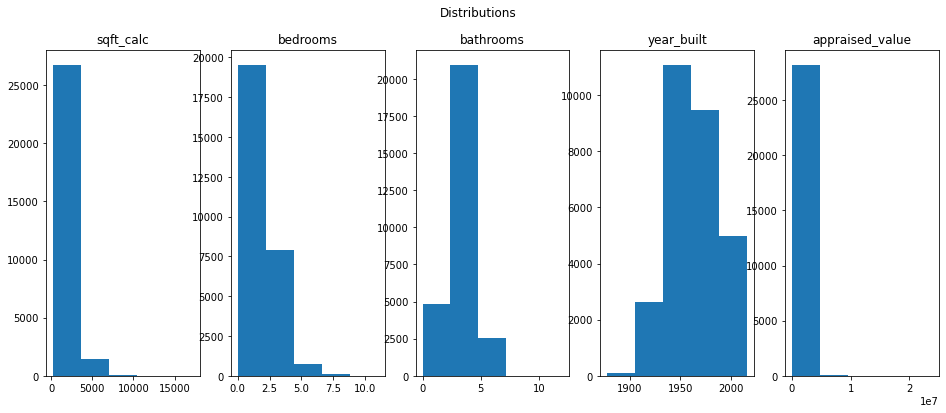

In [13]:
# Plot the distributions
plt.figure(figsize=(16, 6))

# List of columns
cols = ['sqft_calc', 'bedrooms', 'bathrooms', 'year_built', 'appraised_value']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,5, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    plt.suptitle('Distributions')

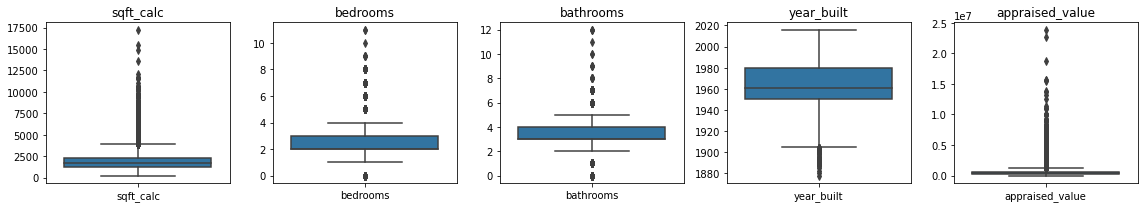

In [14]:
#visualize distribution and outliers
# List of columns
cols = ['sqft_calc', 'bedrooms', 'bathrooms', 'year_built', 'appraised_value']

plt.figure(figsize=(16, 3))

for i, col in enumerate(cols):

    # i starts at 0, but plot should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[[col]])

    # Hide gridlines.
    plt.grid(False)

    # sets proper spacing between plots
    plt.tight_layout()
    
plt.show()

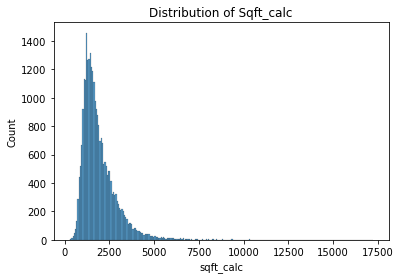

In [15]:
#sqft calc distribution
sns.histplot(data=df.sqft_calc)
plt.title('Distribution of Sqft_calc')
plt.show()

In [16]:
# descriptive stats for sqft calc to help to understand outliers
df.sqft_calc.describe()

count    28287.000000
mean      1928.980521
std        991.066558
min        240.000000
25%       1276.000000
50%       1668.000000
75%       2317.000000
max      17245.000000
Name: sqft_calc, dtype: float64

In [17]:
#finding IQR of sqft calc to find outliers
q1_sqft = df['sqft_calc'].quantile(0.25)
q3_sqft = df['sqft_calc'].quantile(0.75)
iqr_sqft = q3_sqft - q1_sqft

print(f'IQR for total square feet is: {iqr_sqft}')
print(f'Q3 for total square feet is: {q3_sqft}')
print(f'Q1 for total square feet is: {q1_sqft}')

IQR for total square feet is: 1041.0
Q3 for total square feet is: 2317.0
Q1 for total square feet is: 1276.0


In [18]:
lowerbound_sqft = q1_sqft - (1.5 * iqr_sqft)
upperbound_sqft = q3_sqft + (1.5 * iqr_sqft)
print(f'Lower bounds for Square Feet  is: {lowerbound_sqft}')
print(f'Upper bounds for Square Feet is: {upperbound_sqft}')

Lower bounds for Square Feet  is: -285.5
Upper bounds for Square Feet is: 3878.5


In [19]:
#remove outliers for sqft
df= df[df.sqft_calc > lowerbound_sqft]
df= df[df.sqft_calc < upperbound_sqft]

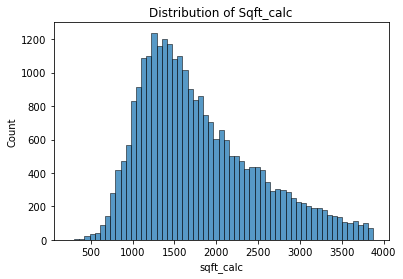

In [20]:
#sqft calc distribution with outliers removed
sns.histplot(data=df.sqft_calc)
plt.title('Distribution of Sqft_calc')
plt.show()

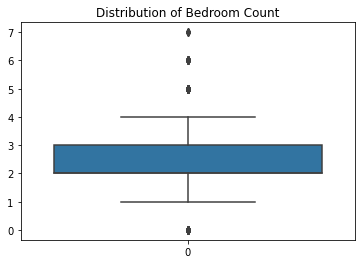

In [21]:
# Bedrooms distribution and outliers
sns.boxplot(data=df.bedrooms)
plt.title('Distribution of Bedroom Count')
plt.show()

In [22]:
# descriptive statistics of bedrooms
df.bedrooms.describe()

count    27080.000000
mean         2.139106
std          0.816685
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: bedrooms, dtype: float64

In [23]:
# finding IQR of bedrooms to find outliers
q1_bed = df['bedrooms'].quantile(0.25)
q3_bed = df['bedrooms'].quantile(0.75)
iqr_bed = q3_bed - q1_bed
print(f'IQR for bedrooms is: {iqr_bed}')
print(f'Q3 for bedrooms is: {q3_bed}')
print(f'Q1 for bedrooms is: {q1_bed}')

IQR for bedrooms is: 1.0
Q3 for bedrooms is: 3.0
Q1 for bedrooms is: 2.0


In [24]:
# in order to find upper and lower bounds, must use following formula
lowerbound_bed = q1_bed - (1.5 * iqr_bed)
upperbound_bed = q3_bed + (1.5 * iqr_bed)
print(f'Lower bounds for bedroom count is: {lowerbound_bed}')
print(f'Upprt bounds for bedroom count is: {upperbound_bed}')

Lower bounds for bedroom count is: 0.5
Upprt bounds for bedroom count is: 4.5


In [25]:
#remove outliers for bedrooms
df= df[df.bedrooms > lowerbound_bed]
df= df[df.bedrooms < upperbound_bed]

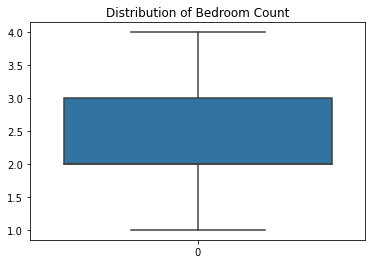

In [26]:
# Bedrooms distribution after ouliers removed
sns.boxplot(data=df.bedrooms)
plt.title('Distribution of Bedroom Count')
plt.show()

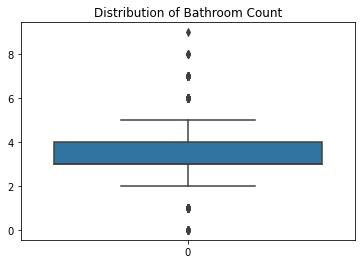

In [27]:
# visualize Bathroom outliers
sns.boxplot(data=df.bathrooms)
plt.title('Distribution of Bathroom Count')
plt.show()

In [28]:
# descriptive statistics of bathrooms
df.bathrooms.describe()

count    26824.000000
mean         3.236169
std          0.868768
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          9.000000
Name: bathrooms, dtype: float64

In [29]:
# finding IQR of bathrooms to find outliers
q1_bath = df['bathrooms'].quantile(0.25)
q3_bath = df['bathrooms'].quantile(0.75)
iqr_bath = q3_bath - q1_bath

print(f'IQR for bathrooms is: {iqr_bath}')
print(f'Q3 for bathrooms is: {q3_bath}')
print(f'Q1 for bathrooms is: {q1_bath}')

IQR for bathrooms is: 1.0
Q3 for bathrooms is: 4.0
Q1 for bathrooms is: 3.0


In [30]:
lowerbound_bath = q1_bath - (1.5 * iqr_bath)
upperbound_bath = q3_bath + (1.5 * iqr_bath)
lowerbound_bath, upperbound_bath
print(f'Lower bounds for bathroom count is: {lowerbound_bath}')
print(f'Upper bounds for bathroom count is: {upperbound_bath}')

Lower bounds for bathroom count is: 1.5
Upper bounds for bathroom count is: 5.5


In [31]:
# remove outliers for bathroom
df= df[df.bathrooms > lowerbound_bath]
df= df[df.bathrooms < upperbound_bath]

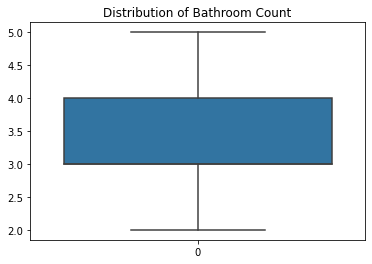

In [32]:
# bedroom outliers have been removed
sns.boxplot(data=df.bathrooms)
plt.title('Distribution of Bathroom Count')
plt.show()

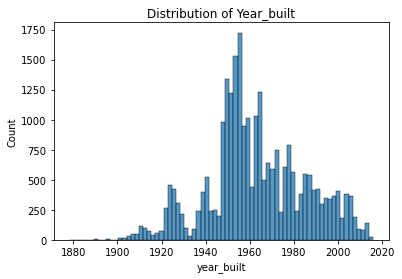

In [33]:
# year built distribution
sns.histplot(data=df.year_built)
plt.title('Distribution of Year_built')
plt.show()

In [34]:
# descriptive statistics of Year built
df.year_built.describe()

count    26303.000000
mean      1963.076455
std         22.220516
min       1878.000000
25%       1950.000000
50%       1960.000000
75%       1978.000000
max       2016.000000
Name: year_built, dtype: float64

In [35]:
# finding IQR of year built to find outliers
q1_yb = df['year_built'].quantile(0.25)
q3_yb = df['year_built'].quantile(0.75)
iqr_yb = q3_yb - q1_yb
print(f'IQR for year_built is: {iqr_yb}')
print(f'Q3 for year_built is: {q3_yb}')
print(f'Q1 for year_built is: {q1_yb}')

IQR for year_built is: 28.0
Q3 for year_built is: 1978.0
Q1 for year_built is: 1950.0


In [36]:
lowerbound_yb = q1_yb - (1.5 * iqr_yb)
upperbound_yb = q3_yb + (1.5 * iqr_yb)
lowerbound_yb, upperbound_yb
print(f'Lower bounds for year built count is: {lowerbound_yb}')
print(f'Upper bounds for year built count is: {upperbound_yb}')

Lower bounds for year built count is: 1908.0
Upper bounds for year built count is: 2020.0


In [37]:
# remove outliers for year built
df= df[df.year_built > lowerbound_yb]
df= df[df.year_built < upperbound_yb]

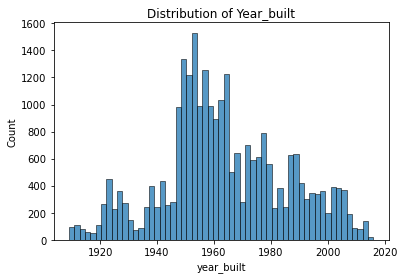

In [38]:
# year built outliers have been removed
sns.histplot(data=df.year_built)
plt.title('Distribution of Year_built')
plt.show()

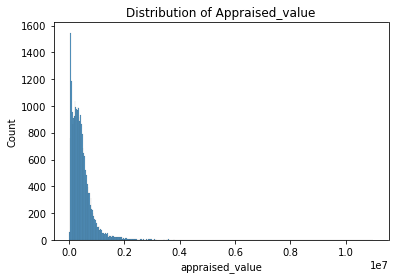

In [39]:
# appraised value distribution
sns.histplot(data=df.appraised_value)
plt.title('Distribution of Appraised_value')
plt.show()

In [40]:
# descriptive statistics of Appraised Value
df.appraised_value.describe()

count    2.613600e+04
mean     4.529173e+05
std      4.327962e+05
min      1.000000e+03
25%      1.914578e+05
50%      3.643825e+05
75%      5.797545e+05
max      1.100000e+07
Name: appraised_value, dtype: float64

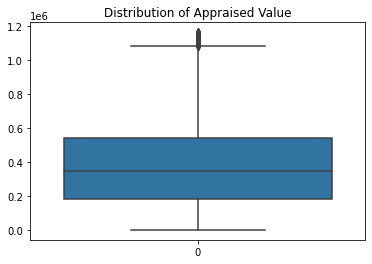

In [50]:
# visualize appraised value outliers
sns.boxplot(data=df.appraised_value)
plt.title('Distribution of Appraised Value')
plt.show()

In [51]:
# finding IQR of Appraised value to find outliers
q1_av = df['appraised_value'].quantile(0.25)
q3_av = df['appraised_value'].quantile(0.75)
iqr_av = q3_av - q1_av
print(f'IQR for appraised_value is: {iqr_av}')
print(f'Q3 for appraised_value is: {q3_av}')
print(f'Q1 for yappraised_value is: {q1_av}')

IQR for appraised_value is: 358959.5
Q3 for appraised_value is: 541000.0
Q1 for yappraised_value is: 182040.5


In [52]:
lowerbound_av = q1_av - (1.5 * iqr_av)
upperbound_av = q3_av + (1.5 * iqr_av)
lowerbound_av, upperbound_yb
print(f'Lower bounds for year built count is: {lowerbound_av}')
print(f'Upper bounds for year built count is: {upperbound_av}')

Lower bounds for year built count is: -356398.75
Upper bounds for year built count is: 1079439.25


In [53]:
# remove outliers for appraised value
df= df[df.appraised_value > lowerbound_av]
df= df[df.appraised_value < upperbound_av]

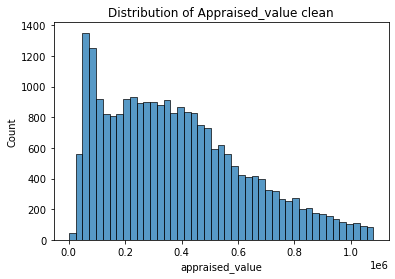

In [54]:
# year built outliers have been removed
sns.histplot(data=df.appraised_value)
plt.title('Distribution of Appraised_value clean')
plt.show()

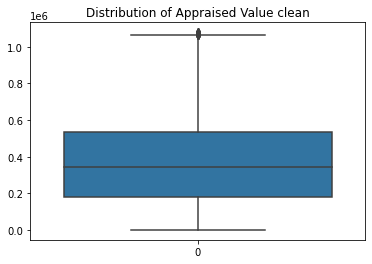

In [55]:
# visualize appraised value outliers
sns.boxplot(data=df.appraised_value)
plt.title('Distribution of Appraised Value clean')
plt.show()

In [57]:
# descriptive statistics of Appraised Value
df.appraised_value.describe()

count    2.465200e+04
mean     3.793425e+05
std      2.441179e+05
min      1.000000e+03
25%      1.803748e+05
50%      3.444030e+05
75%      5.332990e+05
max      1.079282e+06
Name: appraised_value, dtype: float64

In [58]:
# split the data 
train_validate, test = train_test_split(df, test_size=.2,random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
X_train = train.drop(columns=['appraised_value'])
y_train = train.appraised_value

X_validate = validate.drop(columns=['appraised_value'])
y_validate = validate.appraised_value

X_test = test.drop(columns=['appraised_value'])
y_test = test.appraised_value

In [59]:
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (13804, 13)
validate -> (5917, 13)
test -> (4931, 13)


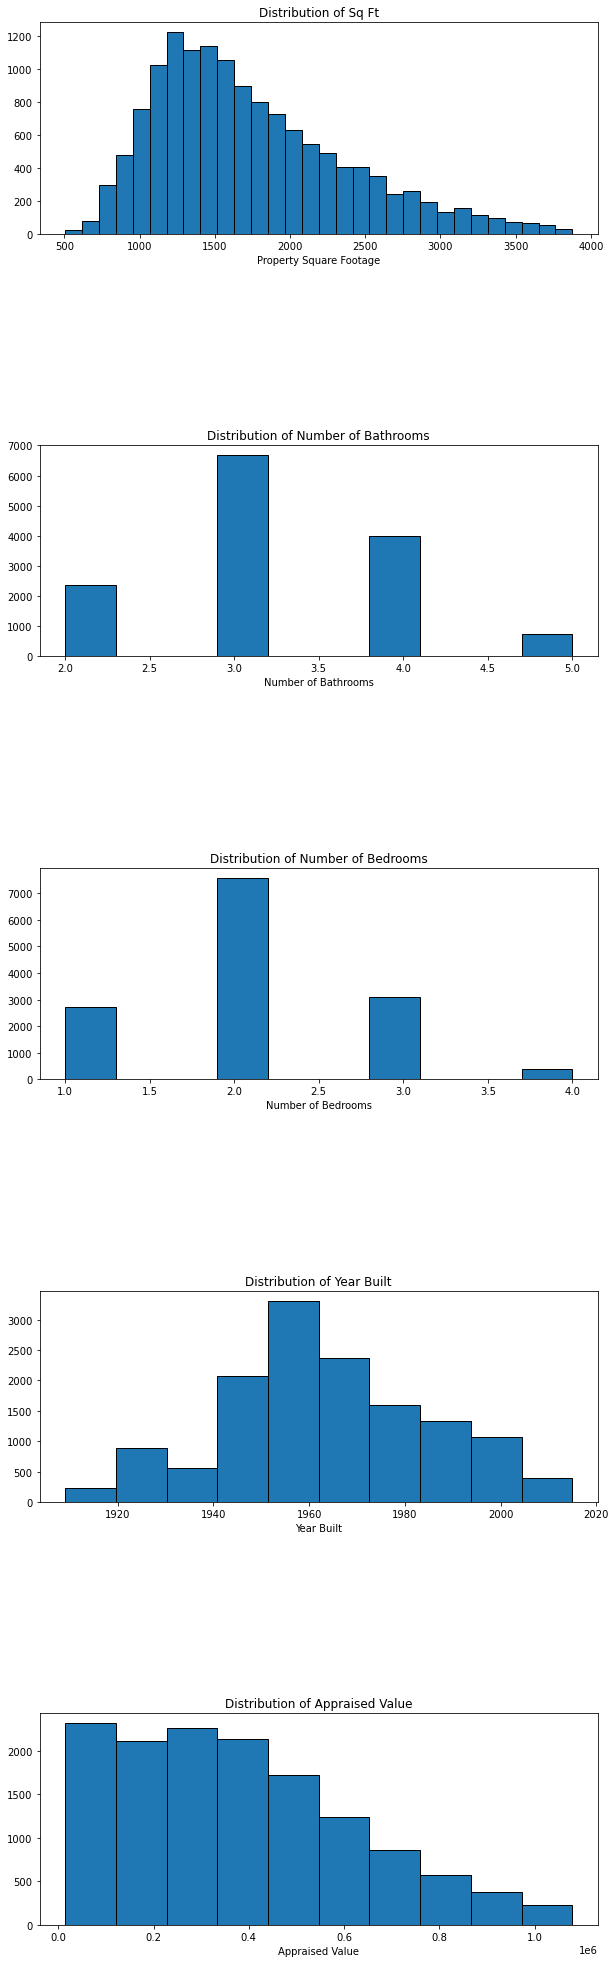

In [60]:
#checking distributions of our selected features/univariate exploration
plt.figure(figsize=(10,35))
plt.subplot(5,1,1, xlabel = 'Property Square Footage', title='Distribution of Sq Ft')
plt.hist(data=train, x='sqft_calc', bins = 30,ec='black')

plt.subplot(5,1,2, xlabel = 'Number of Bathrooms',title='Distribution of Number of Bathrooms')
plt.hist(data=train, x='bathrooms', ec='black')

plt.subplot(5,1,3, xlabel = 'Number of Bedrooms', title='Distribution of Number of Bedrooms')
plt.hist(data=train, x='bedrooms',ec='black')

plt.subplot(5,1,4, xlabel = 'Year Built',title='Distribution of Year Built')
plt.hist(data=train, x='year_built',ec='black')

plt.subplot(5,1,5, xlabel = 'Appraised Value',title='Distribution of Appraised Value')
plt.hist(data=train, x='appraised_value',ec='black')

plt.subplots_adjust(hspace=1)
plt.show()

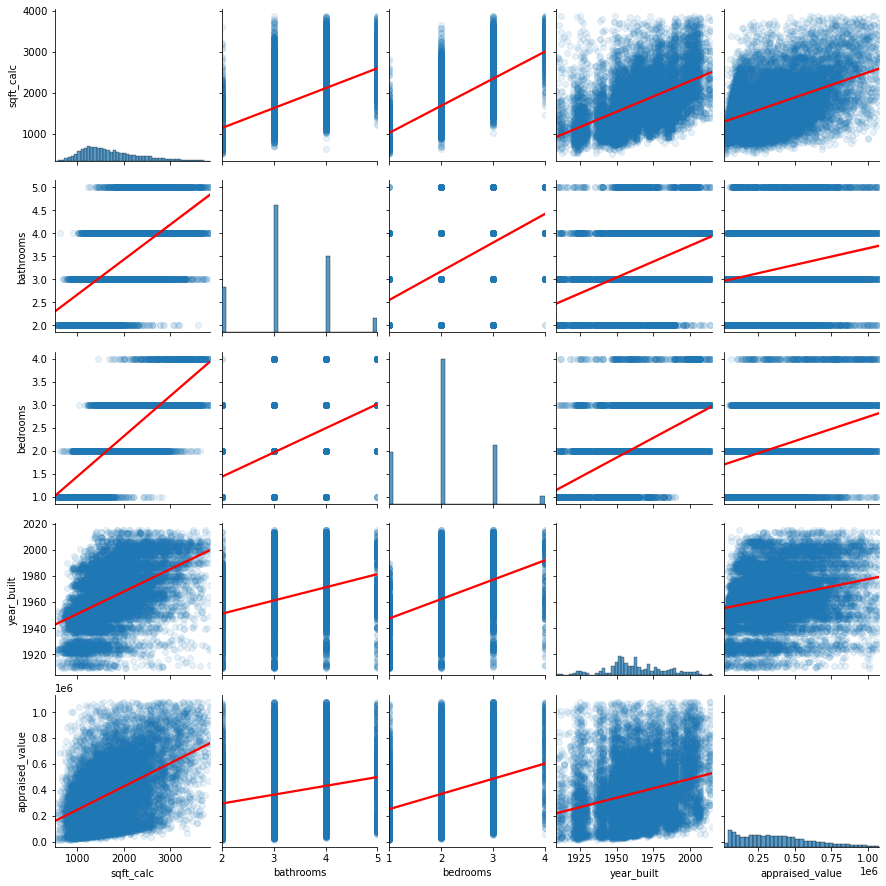

In [65]:
# pairplots
cols = ['sqft_calc', 'bathrooms', 'bedrooms', 'year_built', 'appraised_value']
plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.7}}
sns.pairplot(train[cols], hue=None, kind="reg",plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
plt.show()

In [ ]:
# a t test for bedrooms and value, I picked 3 because it is roughly the mean number of bedrooms for all selected houses
# The results suggest they are related to each other.
null_hypothesis = "Houses with 3 bedrooms or more and houses with less than 3 bedrooms are independent to value of home"
alternative_hypothesis = "Houses with 3 bedrooms or more and houses with less than 3 bedrooms are related to value of home"
a = 0.05 #a for alpha 

two_or_more_beds = train[train.beds>=2]
less_than_three_beds = train[train.beds<2]
t, p = stats.ttest_ind(three_or_more_beds.tax_value, less_than_three_beds.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')